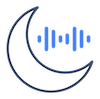

# Getting Started with Moonshine Voice

[Moonshine Voice](https://github.com/moonshine-ai/moonshine/) is a new local AI library for building live speech applications, based around the Moonshine family of speech to text models. It's built to be easy to run and integrate into your own projects, without requiring any prior knowledge of speech workflows.

This notebook ([open in Colab](https://colab.research.google.com/github/moonshine-ai/moonshine-v2/blob/main/python/getting-started-with-moonshine-voice.ipynb)) shows how to install and use the library in Python.

## Table of Contents

- [How to Install](#how-to-install)
- [Testing the Install](#testing-the-install)
- [Transcribing a File](#transcribing-a-file)
- [Transcribing Live Audio](#transcribing-live-audio)
- [Beyond Transcription](#beyond-transcription)
- [Intent Recognition with Sentence Embeddings](#intent-recognition-with-sentence-embeddings)
- [Next Steps](#next-steps)

## How to Install

Moonshine Voice is available as a regular [Python package on PyPi](https://pypi.org/project/moonshine-voice/), so you can install it using `pip`:

In [ ]:
!pip install moonshine-voice

This should install the latest version of the library. It supports Linux x86-64, Linux arm64, MacOS, Windows x86-64, and has a specialized version targeting Raspberry Pis.

## Testing the Install

To make sure the installation worked, run the test for the [`Transcriber`](https://github.com/moonshine-ai/moonshine-v2?tab=readme-ov-file#transcriber) class:

In [ ]:
!python -m moonshine_voice.transcriber

You should see a lot of messages describing the conversion of [an audio file](https://github.com/moonshine-ai/moonshine-v2/raw/refs/heads/main/test-assets/two_cities.wav) of me reading the introduction to [A Tale of Two Cities](https://www.gutenberg.org/ebooks/98) into text. Don't worry about how verbose the logs are for now, those messages are just there to illustrate how the [event system works](), which we'll cover later on. You can listen to the file below.

In [ ]:
import moonshine_voice
import os
from IPython.display import Audio
Audio(os.path.join(moonshine_voice.get_assets_path(), "two_cities.wav"))

## Transcribing a File

Moonshine Voice is focused on applications where you need to understand user's speech in real time, but since notebooks like this don't allow microphone access, the first example we'll show will run on [a pre-recorded audio file](https://github.com/moonshine-ai/moonshine-v2/raw/refs/heads/main/test-assets/beckett.wav) of one of my favorite Beckett quotes:

In [ ]:
# Download the audio file.
! curl -O -L 'https://github.com/moonshine-ai/moonshine/raw/refs/heads/main/test-assets/beckett.wav'

# Import the pip package for Moonshine Voice (notice the underscore, not dash!).
import moonshine_voice

# This returns a path and model type for a particular language, downloading the
# Moonshine model if necessary and caching it locally.
model_path, model_arch = moonshine_voice.get_model_for_language("en")

# Create a Transcriber object using the model information.
transcriber = moonshine_voice.Transcriber(model_path=model_path, model_arch=model_arch)

# To make testing easier, Moonshine Voice includes this convenience function to
# load the PCM audio data from a .wav file, without requiring any additional
# packages like librosa.
audio_data, sample_rate = moonshine_voice.load_wav_file("beckett.wav")

# Extract the text from the spoken audio in the file.
transcript = transcriber.transcribe_without_streaming(audio_data)

# Display the results, line by line.
for line in transcript.lines:
  print(line)

Audio("beckett.wav")

This clip is about ten seconds long, and has the speech "*Ever tried, ever failed. No matter. Try again. Fail again. Fail better.*". If you look at the output you can see the text broken out into individual lines, as well as a lot of other information.

The [`Transcript`](https://github.com/moonshine-ai/moonshine-v2/tree/main?tab=readme-ov-file#transcript) that's returned from the [`transcribe_without_streaming()`](https://github.com/moonshine-ai/moonshine-v2/tree/main?tab=readme-ov-file#transcriber-transcribe-without-streaming) function contains this list of [`TranscriberLine`](https://github.com/moonshine-ai/moonshine-v2/tree/main?tab=readme-ov-file#transcriberline)s. Each has the kind of information you'll be familiar with if you've used libraries more focused on batch processing, such as the excellent [whisper.cpp](https://github.com/ggml-org/whisper.cpp), such as the extracted text and the time and duration. You'll notice that there's also a speaker number associated with each line, since we offer speaker identification (aka diarization) as a default part of our pipeline.

You'll notice a lot of other metadata in there too. You don't have to worry about this for most of your applications, but a couple worth mentioning are the `audio_data`, which is an array containing the section of audio data the text was extracted from, and `line_id` and `speaker_id` which are unique-ish global identifiers designed to be storable references for the line and speaker over time.

## Transcribing Live Audio

As I mentioned at the start, the library is designed for live audio, so running it on files doesn't do a good job of demonstrating how you could use this in a real application. Unfortunately notebooks like this don't make it easy to access a microphone in the streaming way you would in a product, but we can at least simulate that by feeding the audio from a file into the transcriber in incremental chunks instead of all at once.

For batch processing, you usually just want something like a [`Transcript`](https://github.com/moonshine-ai/moonshine-v2/tree/main?tab=readme-ov-file#transcript) object for each file, so you can do further processing. I've found this kind of API isn't a great fit for live speech applications though. There the results will be constantly changing as more speech is heard, and if you just get a list of lines every time there's a change, it gets hard to track what's been updated and respond in the right way.

Instead, the core idea behind the Moonshine Voice framework is that what applications actually want to know about live voice streams is when there's been an important change - for example somebody started or finished speaking. If you've worked on graphical user interfaces, this is similar to how you receive events when a user takes an action.

You'll see below that we attach a class that implements the [`TranscriptEventListener`](https://github.com/moonshine-ai/moonshine-v2/tree/main?tab=readme-ov-file#transcripteventlistener) that is called when [`TranscriptEvent`](https://github.com/moonshine-ai/moonshine-v2/tree/main?tab=readme-ov-file#transcriptevent)s are generated while we're feeding a stream of audio chunks into the [`Transcriber`](https://github.com/moonshine-ai/moonshine-v2/tree/main?tab=readme-ov-file#transcriber).

In [ ]:
# Code that the application defines to control what happens when a speech
# event is detected.
class TestListener(moonshine_voice.TranscriptEventListener):

  # Someone started speaking a new phrase.
  def on_line_started(self, event: moonshine_voice.LineStarted):
    print(f"Line started: {event.line.text}")

  # The extracted text for this line has changed.
  def on_line_text_changed(self, event: moonshine_voice.LineTextChanged):
    if event.line.has_speaker_id:
      speaker_prefix = f". Speaker #{event.line.speaker_index}"
    else:
      speaker_prefix = ""
    print(f"Line text changed{speaker_prefix}: {event.line.text}")

  # There's been a pause in speech, so the active line is completed.
  # Further speech will start a new line.
  def on_line_completed(self, event: moonshine_voice.LineCompleted):
    speaker_prefix = f"Speaker #{event.line.speaker_index}: "
    print(f"{speaker_prefix}{event.line.text}")

# Create an instance of our listener, and attach it to the Transcriber.
listener = TestListener()
transcriber.add_listener(listener)

# Begin a new session. Required before you start adding audio chunks.
transcriber.start()

# Loop through the audio data in chunks to simulate live streaming
# from a microphone or other source.
chunk_duration = 0.2
chunk_size = int(chunk_duration * sample_rate)
for i in range(0, len(audio_data), chunk_size):
    chunk = audio_data[i : i + chunk_size]
    transcriber.add_audio(chunk, sample_rate)

# Finalize the session. This ensures that a completion event is called for
# the last line, if the user was still speaking at the end.
_ = transcriber.stop()

So, why did we go with this event-based approach? The advantage might not be obvious from this simple example, but if you think about building an application that needs to display a transcription of live speech, hopefully it makes more sense.

Typically that kind of product needs to show responses while speech is on-going to provide a good user experience. This might involve showing a "..." pending text bubble when new speech is first detected, which can be triggered by the line started event. Then as a phrase is being spoken, you can update that text bubble with the latest partial text using the text changed event, and then finalize the display with the completely-decoded text when the line completed event fires.

In my experience this is a common scenario, and the alternative of comparing sequential transcript snapshots to determine when to trigger these kinds of UI updates is complex and error-prone. By abstracting that away we've been able to work with live speech at a higher level that's more reliable and easier to work with.

## Beyond Transcription

The API we've covered so far supports use cases that capture and display text from live speech, for example for dictation or taking meeting notes. There's a lot more you can do with voice as an interface though. You can use Moonshine to convert speech into text and then feed that into a large language model, which I often find easier than interacting through typing.

However there are a lot of other use cases where an LLM is either overkill, or may struggle to produce the correct results. Imagine you're trying to control the movement of a robot. There are probably a handful of commands you want it to understand, like "move forward", "stop", "turn left", and so on. The traditional approach to this would be to listen to exact matches to those phrases, possibly with a few variations on each.

In our current LLM era, the obvious approach would be to design a prompt that lists the canonical commands and then ask the model to examine all captured text and return whether there's a match between those phrases. This suffers from some issues though:

 - **Structure**. We want a clear "Which direction?" signal to pass along to the robot's motors. This means constraining the output of the LLM to some structured form like JSON, which increases the complexity of the task and adds an extra way for the recognition to fail.
 - **Probability**. It's often helpful to know how certain the match is. For example you might want the robot to confirm a move if it's uncertain what you want. You can ask an LLM for this, but it's tricky to get back a value that's comparable between phrases, and requires more structure too.
 - **Latency**. For an interface to feel truly responsive you need to provide results to the user within a fraction of a second. Even if you have the compute and memory resources to run a large LLM, the time taken to get an answer is unlikely to be fast enough for user comfort.

 My preferred alternative for many applications is to use sentence embeddings.

## Intent Recognition with Sentence Embeddings

Sentence embeddings are fixed-length vectors with the property that phrases with similar meanings are near to each other in the n-dimensional space of those vectors. For example "Go forward" and "Move ahead" produce vectors that are close, but "Eat a ham sandwich" and "Turn left" will be far apart.

There are a lot of models available that can produce these embeddings. For Moonshine we've integrated [a 300 million parameter Gemma embedding model from Google](https://huggingface.co/google/embeddinggemma-300m). This runs entirely on-device, and is around 200MB in file size, thanks to quantized weights.

The API to recognize user intents relies on this model under the hood, but the interface uses the same listener/event model as transcription to tie into your application logic. The way it works is that you register the kind of phrases you want to take action on, and the library calls you back when somebody says something with a similar meaning.

In [ ]:
# Download an audio file with some phrases that match the robot movement intents.
! curl -O -L 'https://github.com/moonshine-ai/moonshine/raw/refs/heads/main/test-assets/intent.wav'
intent_audio_data, intent_sample_rate = moonshine_voice.load_wav_file("intent.wav")
Audio("intent.wav")

In [ ]:
# Download the embedding model if it's not already cached locally.
embedding_model_path, embedding_model_arch = moonshine_voice.get_embedding_model(variant="q4")

# Create the recognizer instance.
intent_recognizer = moonshine_voice.IntentRecognizer(
  model_path=embedding_model_path,
  model_arch=embedding_model_arch,
  model_variant="q4",
  threshold=0.6)

# These are the functions that get called back when an intent is recognized.
# In a real application they'd send motor control commands, but for this example
# we just log when they're triggered.
def on_move_forward(trigger: str, utterance: str, similarity: float):
  print(f"'{utterance}' triggered moving forward with {similarity:.2f} confidence!")

def on_move_backward(trigger: str, utterance: str, similarity: float):
  print(f"'{utterance}' triggered moving backward with {similarity:.2f} confidence!")

def on_turn_left(trigger: str, utterance: str, similarity: float):
  print(f"'{utterance}' triggered turning left with {similarity:.2f} confidence!")

def on_turn_right(trigger: str, utterance: str, similarity: float):
  print(f"'{utterance}' triggered turning right with {similarity:.2f} confidence!")

# Register the callback functions, together with the kind of phrase that
# should trigger them.
intent_recognizer.register_intent("move forward", on_move_forward)
intent_recognizer.register_intent("move backward", on_move_backward)
intent_recognizer.register_intent("turn left", on_turn_left)
intent_recognizer.register_intent("turn right", on_turn_right)

# The recognizer connects to the speech pipeline by listening for line completed
# events, checking for matches, and then calls back the corresponding event
# function if one was found.
transcriber.remove_all_listeners()
transcriber.add_listener(intent_recognizer)

# Simulate incoming live audio. The action events will be triggered once the
# audio chunks containing each matching sentence have been added.
transcriber.start()

chunk_duration = 0.2
chunk_size = int(chunk_duration * intent_sample_rate)
for i in range(0, len(intent_audio_data), chunk_size):
    chunk = intent_audio_data[i : i + chunk_size]
    transcriber.add_audio(chunk, intent_sample_rate)

_ = transcriber.stop()


This sentence embedding approach isn't limited to just command recognition, it can be applied to a lot of other interactive use cases too. [Here's a video demonstrating a local voice assistant for a dishwasher](https://www.youtube.com/watch?v=TEVrOY-sMA8), that uses Moonshine to understand user questions and responds with answers from the manual. In general classifying what a user has just said is often a good first step to retrieving a response, even if it will be generated.

## Next Steps

Now that you've mastered the fundamentals of the library in Python, the good news is that everything you've learned will work on Android, and iOS, in Swift MacOS apps, and C++ projects on Windows. The APIs and functionality are the same across all platforms, so I'm looking forward to seeing what you build.

To learn more, you can [join our Discord](https://discord.gg/27qp9zSRXF), and if you have any questions or comments [please do get in touch](mailto:pete@moonshine.ai).

Thanks,

[Pete Warden](https://petewarden.com)